# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 2: kNN and Linear Regression

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Hayden Joy, Lauren Baker, and Kaela Nelson<br/>



<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with k-Nearest Neighbors (kNN) and Linear Regression. In the course thus far, we have discussed some aspects of dealing with data, including scraping data from the web, organizing it using dictionaries and Pandas dataframes, and visualizing it using Matplotlib plotting functionality. Now we're moving on to data modeling!

It is useful to make models to fit and predict data. **Why?** To understand the underlying behavior of your data.

By the end of this section, you should feel comfortable: 
    
- Performing exploratory data analysis (EDA) on dataset
- Splitting this dataset into a training and test set (and understanding why you need to do this!)
- Applying simple models (kNN and Linear Regression) to your data using sklearn and statsmodels packages
- Using these models to understand relationships between the response variable and the predictors (also can be called features or descriptors)
- Evaluating model performance using metrics such as $R^2$ 

For this section we will be using the following packages:

In [2]:
#Matrices, Dataframe and Plotting Operations
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Model packages
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from statsmodels.api import OLS
import statsmodels.api as sm

## Load in the Bikeshare dataset and perform preliminary EDA

Here, we will work with a dataset collected from the Capital Bikeshare program in Washington D.C. This dataset contains over two years of data on the total number of bike rentals per day, as well as 10 attributes describing the day and its weather (see below for description of these variables as recorded in the dataset). The data set is provided in the file 'bikeshare.csv'.

The task is to build a regression model to **predict the total number of bike rentals in a given day** (known as the response variable) based on attributes about the day (known as the descriptors). Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city.

**Description of variables**

- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent, or relative outdoor, or real feel temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)
- **count** (response variable i.e. total number of bike rentals on the day)

**Load the BikeShare dataset**

In [3]:
bikeshare = pd.read_csv('../data/bikeshare.csv')
print("Length of Dataset:",len(bikeshare))
display(bikeshare.head())

Length of Dataset: 731


,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


**Drop unnecessary columns**

In [4]:
bikeshare = bikeshare.drop(columns=['Unnamed: 0'])
print("Length of Dataset:",len(bikeshare))
display(bikeshare.head())

Length of Dataset: 731


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


**Use the describe feature of Pandas to summarize data** 

In [5]:
display(bikeshare.describe())

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789406,0.190486,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242910,0.077498,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.022392,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.134950,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.666700,0.180975,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020850,0.233214,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.507463,10045.000000


**Note, we can also use the groupby function to look at mean stats, aggregated by month in this case**

In [6]:
bikeshare.groupby('month').mean()

,season,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
month,,,,,,,,,,
1.0,1.000000,0.048387,2.870968,0.645161,1.419355,-0.080645,4.145161,58.582827,0.206303,2498.306452
2.0,1.000000,0.035088,3.000000,0.684211,1.368421,3.912281,7.807018,56.746468,0.215684,2824.315789
3.0,1.354839,0.000000,3.096774,0.725806,1.451613,9.580645,13.080645,58.847503,0.222699,3822.241935
4.0,2.000000,0.033333,3.000000,0.666667,1.416667,14.583333,17.783333,58.806312,0.234482,4348.600000
5.0,2.000000,0.032258,2.903226,0.693548,1.403226,22.532258,24.661290,68.895831,0.182989,5268.790323
6.0,2.333333,0.000000,3.100000,0.716667,1.233333,28.150000,29.216667,57.580552,0.185420,5547.033333
7.0,3.000000,0.032258,2.935484,0.661290,1.193548,32.580645,33.338710,59.787632,0.166059,5563.677419
8.0,3.000000,0.000000,3.000000,0.741935,1.306452,29.629032,30.096774,63.773010,0.172918,5584.887097
9.0,3.266667,0.033333,3.050000,0.666667,1.500000,23.850000,25.466667,71.471437,0.165945,5653.316667


**Plot the count of bike rentals by month**

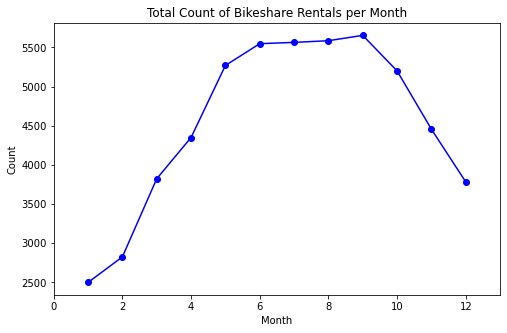

In [7]:
plt.figure(figsize=[8,5])
plt.plot(bikeshare.groupby('month').mean()['count'],'-ob')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Total Count of Bikeshare Rentals per Month')
plt.xlim([0,13])
plt.show()

**Is there a difference between temp and a_temp? Let's plot them both**

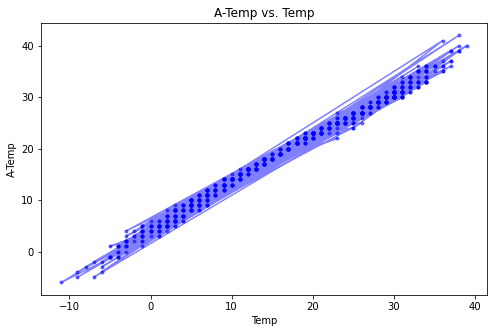

In [52]:
plt.figure(figsize=[8,5])
plt.plot(bikeshare['temp'], bikeshare['atemp'],'.-b', alpha = 0.5) # toggle alpha to 1
plt.xlabel('Temp')
plt.ylabel('A-Temp')
plt.title('A-Temp vs. Temp')
plt.show()

**What did we do wrong here? Why does the plot look like this?**

**Sorting!** Whenever your plot makes zig-zag changes across the scale, it is because ```matplotlib``` is trying to connect the points *sequentially* from the top (using a line plot) and skipping across the scale when $x_{i+1}$ is lower than $x_{i}$. So let's sort.

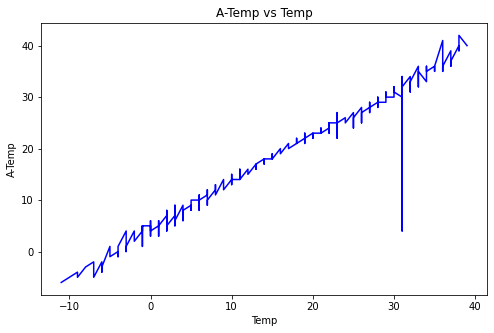

In [9]:
# Sorting
new = bikeshare.sort_values(['temp'])

plt.figure(figsize=[8,5])
plt.plot(new['temp'], new['atemp'],'-b',alpha=1)
plt.xlabel('Temp')
plt.ylabel('A-Temp')
plt.title('A-Temp vs Temp')
plt.show()

**It still looks weird, why?**

Let's have a closer look at the dataframe:

In [10]:
display(new.head(10))

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
176,1.0,1.0,0.0,6.0,0.0,1.0,-11.0,-6.0,40.0000,0.171970,981.0
367,1.0,1.0,0.0,1.0,1.0,1.0,-9.0,-4.0,49.1739,0.158330,1416.0
265,1.0,1.0,0.0,0.0,0.0,1.0,-9.0,-5.0,43.6522,0.246600,986.0
346,1.0,1.0,0.0,3.0,1.0,2.0,-8.0,-3.0,41.4583,0.184700,2368.0
612,1.0,2.0,0.0,3.0,1.0,2.0,-7.0,-2.0,49.4783,0.188839,1605.0
82,1.0,2.0,0.0,0.0,0.0,1.0,-7.0,-5.0,46.4583,0.409212,1529.0
475,1.0,2.0,0.0,4.0,1.0,1.0,-6.0,-2.0,43.7391,0.221935,1538.0
343,1.0,1.0,0.0,0.0,0.0,1.0,-6.0,-4.0,43.4167,0.361950,822.0
270,1.0,1.0,0.0,2.0,1.0,1.0,-6.0,-3.0,44.1250,0.365671,2236.0
457,1.0,1.0,0.0,5.0,1.0,1.0,-5.0,1.0,53.7826,0.126548,6079.0


There are multiple ```atemp``` values for each ```temp``` value, which if not sorted will bounce around at the same x-value. Thus, we need to sort both axes simultaneously.

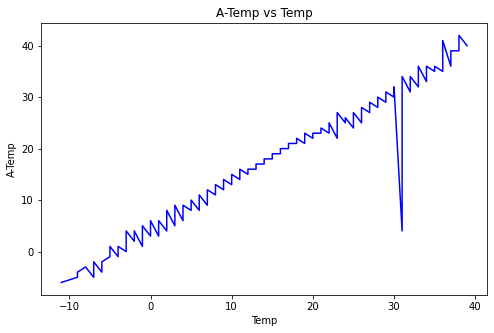

In [11]:
new = bikeshare.sort_values(['temp','atemp'])

plt.figure(figsize=[8,5])
plt.plot(new['temp'], new['atemp'],'-b')
plt.xlabel('Temp')
plt.ylabel('A-Temp')
plt.title('A-Temp vs Temp')
plt.show()

By plotting efficiently, we found an anomaly we would have otherwise overlooked. It looks like there is a problem with the data around ```temp greater than 30``` and ```atemp less than 10```.

**Show all rows in the dataframe where the temp is greater than 30 and the atemp is less than 10**

In [12]:
display(bikeshare[(bikeshare['temp'] > 30) & (bikeshare['atemp'] < 10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
188,3.0,8.0,0.0,5.0,1.0,1.0,31.0,4.0,57.0833,0.231354,7148.0


Anomaly! ```atemp``` and ```temp``` are usually lineary related except at this one datapoint. Now, we get to make a judgement call as to whether we should keep the datapoint. For this example, we will drop this datapoint, but we will come back to the question of how to manage abnormal/missing data after the lecture on Missing Data and Imputation. 

In [13]:
bikeshare = bikeshare.drop([188])

We can now try what we wrote and we should end up with no rows in the dataframe where the temp is greater than 30 and the atemp is less than 10

In [14]:
display(bikeshare[(bikeshare['temp'] > 30) & (bikeshare['atemp'] < 10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count


This EDA enabled us to spot this anomoly and clean the data (dropping a data point that may have influenced the model).

## Splitting up the data into a training set and a test set using the 'train_test_split' function from sklearn

Now that we have an idea of what the data looks like, we want to predict the count. We will be randomly splitting up the data into a **training** and a **testing** set. [Scikit learn (sklearn)](https://scikit-learn.org/stable/index.html) has a function that does this for us, called "train_test_split."

What is the need for training and testing data sets?
The **training** set will be used to train the model, while the **testing** set will be used to quantify how well that model does on data it has never seen before. Evaluating the accuracy of a model on a **testing** set ensures that the model doesn't overfit our training data.

**Why random split?** Randomization helps manage uncontrollable confounding variables within the data. 

**Let us first create a function that will randomly split the data up into a 70-30 split, with 70% of the data going into the training set**

In [15]:
# from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(bikeshare, test_size=0.30, random_state=42) 

print("Length of Training set = ",len(train_data))
print("Length of Testing set  = ",len(test_data))

Length of Training set =  511
Length of Testing set  =  219


Random state of 42 is arbitrary (Pavlos favorite number, google for "the number of universe") but fixing this value will produce the same randomization of data every time (useful for homework grading, research, etc.).

**Calculate the ratio of the number of points in the training set to the number of points in the testing set to see if we have split the data correctly**

In [16]:
print('The training data length is the', 100*len(train_data)/len(bikeshare),'% of the total dataset length.')
print('The testing  data length is the', 100*len(test_data)/len(bikeshare),'% of the total dataset length.')

The training data length is the 70.0 % of the total dataset length.
The testing  data length is the 30.0 % of the total dataset length.


# Time for Break Out Room 1

**Goal: Practice using train_test_split and visualizing data using matplotlib**

**Directions:**
1. Load "sim_data.csv" file into dataframe
    - Inspect data
    - Drop any unncessary columns
1. Split data into 80% training data and 20% test data ("80-20 train-test split")
1. Plot training and test data in single plot
    - Color training data in blue and test data in red. Also, use different markers for the two sets, e.g. o and *
    - Include a legend, title, and axes labels! 
    
*Hint: dont forget to sort!*

In [17]:
# your code here


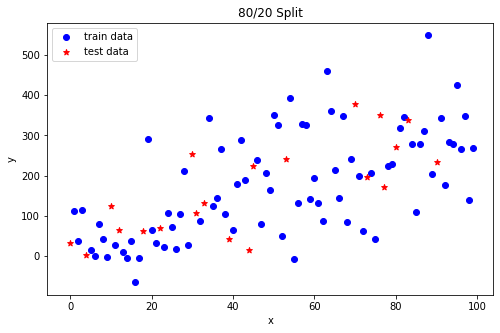

In [3]:
# %load ../solutions/breakout_1_sol.py
# read in data
data = pd.read_csv("../data/sim_data.csv")

# drop Unnamed column
data.drop(columns=["Unnamed: 0"], inplace=True)

# split into training and testing with 80/20 split, random_state=42
train_data1, test_data1 = train_test_split(data, test_size=0.20, random_state=42)

# plot results 80/20 split
plt.figure(figsize=[8,5])
plt.scatter(train_data1.x, train_data1.y, c="blue", marker='o', label="train data")
plt.scatter(test_data1.x, test_data1.y,c="red", marker='*', label="test data")
plt.xlabel('x')
plt.ylabel('y')
plt.title("80/20 Split")
plt.legend()
plt.show()



# Now let's do some modeling

**General sklearn model fitting code-structure :**

```
#Split Data into Train and Test Set
x_train, y_train = training_data.drop('Response_Variable', axis=1), training_data['Response_Variable']
x_test, y_test = test_data.drop('Response_Variable', axis=1), test_data['Response_Variable']

#Define Model
model = sklearn_model_name(hyper_parameter1 = value1, hyper_parameter2 = value2)

#Fit Model
model.fit(x_train, y_train)

#Get Prediction
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Evaluate Model
r2_train = model.score(y_train, y_pred_train)
r2_test = model.score(y_test, y_pred_test)

#Print Results
print("Score for Model (Training):", r2_train)
print("Score for Model (Testing) :", r2_test)
```

* Every model has a list of hyperparameters that can be set using sklearn for the specific problem. We find optimal hyperparameters through exploration (one way is cross-validation, which we will discuss soon).

* ```model.fit``` calculates the parameters of your model corresponding to the training data and hyperparameters you provided.

* ```model.predict(X)``` is the standard method called to make the model predict values for a specific X. Depending on if you feed x_train or x_test, you will get a y_prediction_train or y_prediction_test respectively.

* Evaluation of model can vary according to the task at hand i.e. Regression or Classification. For Regression, $R^2$ Score is standard while for Classification, Accuracy (%) is standard.

# kNN Regression

![knn](../fig/knn_1.png)
![knn](../fig/knn_2.png)
![knn](../fig/knn_3.png)


## Using sklearn to implement kNN

We will use the temperature parameter to predict total bike rental count. We can use sklearn to implement kNN, fit the model, and use various metrics to assess our accuracy.

In [20]:
# from sklearn.neighbors import KNeighborsRegressor

# Set kNN hyperparameter:
k = 10

# First, we create the classifier object:
neighbors = KNeighborsRegressor(n_neighbors=k)

# Then, we fit the model using x_train as training data and y_train as target values:
neighbors.fit(train_data[['temp']], train_data['count'])

# Retrieve our predictions:
prediction_knn = neighbors.predict(test_data[['temp']])

# This returns the mean accuracy on the given test data and labels, or in other words, 
# the R squared value -- A constant model that always predicts the expected value of y, 
# disregarding the input features, would get a R^2 score of 1.
r2_train = neighbors.score(train_data[['temp']], train_data['count'])
r2_test = neighbors.score(test_data[['temp']], test_data['count'])
print("Length of Test Data:", len(test_data['count']))
print("R^2 Score of kNN on training set:", r2_train)
print("R^2 Score of kNN on testing set: ", r2_test)

Length of Test Data: 219
R^2 Score of kNN on training set: 0.36710873429408564
R^2 Score of kNN on testing set:  0.19290625155095908


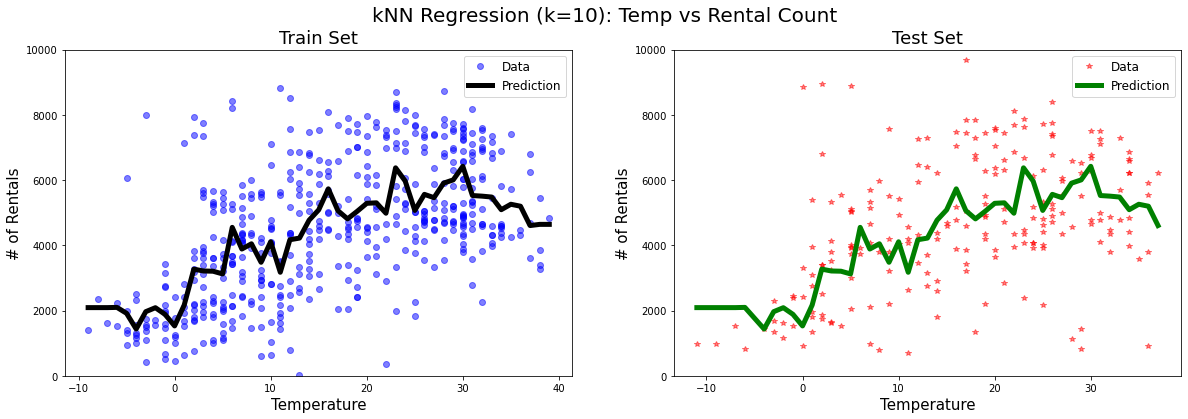

In [21]:
# SubPlots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# train data
axes[0].set_ylim([0,10000])
axes[0].plot(train_data['temp'], train_data['count'], 'bo', alpha = 0.5, label = 'Data' )

sorted_temp = train_data.sort_values(['temp'])
prediction_knn = neighbors.predict(sorted_temp[['temp']])

axes[0].plot(sorted_temp['temp'], prediction_knn, 'k-', linewidth = 5, markersize = 10, label = 'Prediction')
axes[0].set_xlabel('Temperature', fontsize = 15)
axes[0].set_ylabel('# of Rentals', fontsize = 15)
axes[0].set_title("Train Set", fontsize = 18)
axes[0].legend(loc = 'upper right', fontsize = 12)

# test data
axes[1].set_ylim([0,10000])
axes[1].plot(test_data['temp'], test_data['count'],'r*', alpha = 0.5, label = 'Data' )

sorted_temp = test_data.sort_values(['temp'])
prediction_knn = neighbors.predict(sorted_temp[['temp']])

axes[1].plot(sorted_temp['temp'], prediction_knn, 'g-', linewidth = 5, markersize = 10, label = 'Prediction')
axes[1].set_xlabel('Temperature', fontsize = 15)
axes[1].set_ylabel('# of Rentals', fontsize = 15)
axes[1].set_title("Test Set", fontsize = 18)
axes[1].legend(loc = 'upper right', fontsize = 12)

fig.suptitle("kNN Regression (k={}): Temp vs Rental Count".format(k), fontsize = 20)
plt.show()

# Time for Break Out Room 2

**Goal: Practice using sklearn's kNN regression**

**Directions:**
1. Use same dataset from Break Out Room 1 ("sim_data.csv")
1. Perform 70-30 train-test split using a random state of 42 
1. Create a function that implements kNN regression with your choice of k (explore a few different k's)
1. Predict on both training and test data
1. For all kNN models generated, plot the following on the same plot:
    - Original train data = blue
    - Original test data = red
    - Predicted train data = black
    - Predicted test data = green
1. Calculate $R^2$ score 

*Hints:*
- dont forget to sort!
- can make plot colors more transparent using "alpha" and lines thicker using "linewidth"

In [22]:
# your code here


R^2 Score of kNN on training set with k=1: 1.0
R^2 Score of kNN on testing set: with k=1 -0.24443896120147302


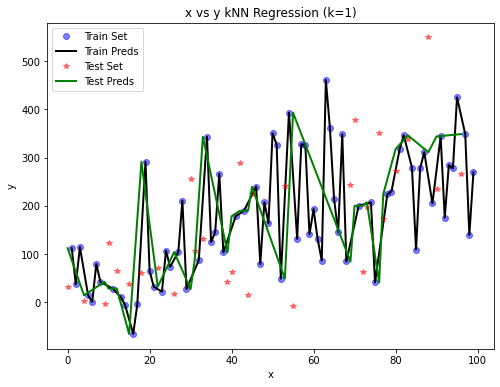

R^2 Score of kNN on training set with k=10: 0.41569204879718624
R^2 Score of kNN on testing set: with k=10 0.3960264344425989


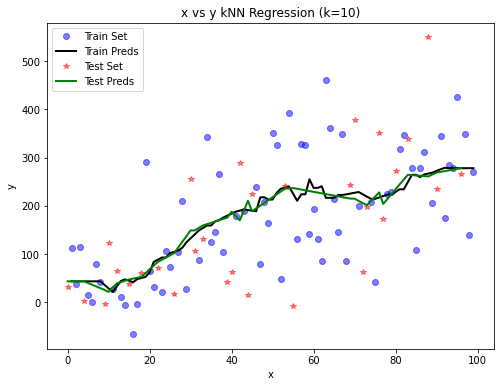

R^2 Score of kNN on training set with k=70: -2.220446049250313e-16
R^2 Score of kNN on testing set: with k=70 -0.0167373824706607


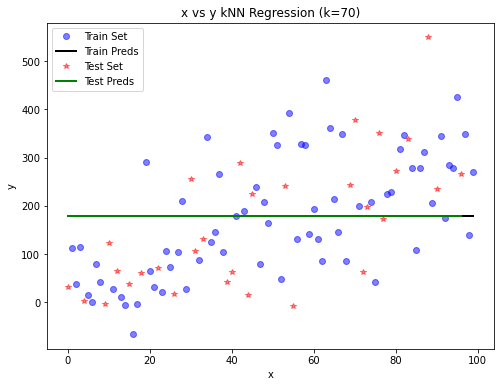

In [24]:
# %load ../solutions/breakout_2_sol.py
# from sklearn.neighbors import KNeighborsRegressor

# split into 70/30, random_state=42
sim_train_data, sim_test_data = train_test_split(data, test_size=0.30, random_state=42)

def knn_model(k, train_data, test_data):
    # create the classifier object
    neighbors = KNeighborsRegressor(n_neighbors=k)

    # fit the model using x_train as training data and y_train as target values
    neighbors.fit(train_data[['x']], train_data['y'])

    sorted_train = train_data.sort_values(['x'])
    sorted_test = test_data.sort_values(['x'])

    # Retreieve our predictions:
    train_preds = neighbors.predict(sorted_train[['x']])
    test_preds = neighbors.predict(sorted_test[['x']])
    
    # find r^2
    r2_train = neighbors.score(train_data[['x']], train_data['y'])
    r2_test = neighbors.score(test_data[['x']], test_data['y'])
    
    print("R^2 Score of kNN on training set with k={}:".format(k), r2_train)
    print("R^2 Score of kNN on testing set: with k={}".format(k), r2_test)
    return sorted_train, sorted_test, train_preds, test_preds, r2_train, r2_test

def plot_predictions_same_plot(k, train_data,test_data, train_preds, test_preds):
    # plot all results on same plot
    plt.figure(figsize=[8,6])
    plt.plot(train_data['x'], train_data['y'], 'bo', alpha = 0.5, label = 'Train Set' )
    plt.plot(train_data['x'], train_preds, 'k-', linewidth = 2, markersize = 10, label = 'Train Preds')
    plt.plot(test_data['x'], test_data['y'], 'r*', alpha = 0.5, label = 'Test Set' )
    plt.plot(test_data['x'], test_preds, 'g-', linewidth = 2, markersize = 10, label = 'Test Preds')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("x vs y kNN Regression (k={})".format(k))
    plt.legend()
    plt.show()

knn_train_preds = []
knn_test_preds = []
knn_r2_train_scores = []
knn_r2_test_scores = []

for k in [1,10,70]:
    sim_sorted_train, sim_sorted_test, sim_train_preds, sim_test_preds, knn_r2_train, knn_r2_test = knn_model(k, sim_train_data,sim_test_data)
    plot_predictions_same_plot(k,sim_sorted_train, sim_sorted_test, sim_train_preds, sim_test_preds)
    knn_train_preds.append(sim_train_preds)
    knn_test_preds.append(sim_test_preds)
    knn_r2_train_scores.append(knn_r2_train)
    knn_r2_test_scores.append(knn_r2_test)


# Linear Regression

![linear regression](../fig/linear_regression.png)

We just went over the kNN prediction method. Now, we will fit the same data using a linear regression model. 

**What is the main difference between a kNN model and linear regression model?** Linear regression specifies the model (whatever the data is, the model will fit a linear line) whereas kNN learns the model and fits the best curve. 

Advantages of linear regression models are that they are very fast and yield an exact optimal solution. For a more in-depth discussion on generalized linear models, please see the Advanced Section on this.

We will use the same training/testing dataset as before and create linear regression objects. We can do this using sklearn (as we did for kNN) as well as with another package called [statsmodels](https://www.statsmodels.org/stable/index.html).

In [25]:
# Label data as X,Y for ease
x_train, y_train = train_data['temp'], train_data['count']
x_test, y_test = test_data['temp'], test_data['count']

You can also split into train test by x and y using train test split

X_train, X_test, y_train, y_test = train_test_split( bikeshare['temp']), bikeshare['count'] )

## Linear Regression using [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**Fit a Linear Regression model using sklearn and take a look at the model's parameters**

In [26]:
from sklearn.linear_model import LinearRegression

lr_sklearn = LinearRegression().fit(x_train.values.reshape(-1,1), y_train) # x data must be 2D array
print('Coefficients:', lr_sklearn.coef_)
print('Intercept:', lr_sklearn.intercept_)

Coefficients: [94.6299874]
Intercept: 2977.527482393689


*Note:* only one coefficient here since only using one descriptor variable (temp)

**Use model to predict on training and testing data and plot prediction**

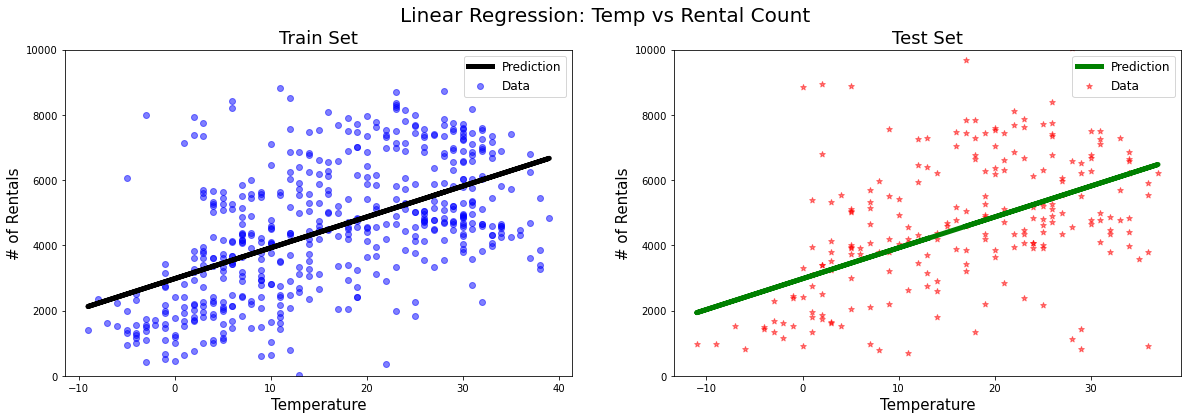

In [27]:
# predict
y_preds_train = lr_sklearn.predict(x_train.values.reshape(-1,1))
y_preds_test = lr_sklearn.predict(x_test.values.reshape(-1,1))

# plot predictions
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

axes[0].scatter(x_train, y_train, color = 'b', alpha = 0.5, label = 'Data')
axes[0].plot(x_train, y_preds_train, 'k', linewidth = 5, label = 'Prediction')
axes[0].set_title('Train Set', fontsize = 18)
axes[1].scatter(x_test, y_test, color = 'r',marker='*', alpha = 0.5, label = 'Data')
axes[1].plot(x_test, y_preds_test, 'g', linewidth = 5, label = 'Prediction')
axes[1].set_title('Test Set', fontsize = 18)

for i, ax in enumerate(axes):
    ax.set_ylim(0,10000)
    ax.set_xlabel('Temperature', fontsize = 15)
    ax.set_ylabel('# of Rentals', fontsize = 15)
    ax.legend(loc = 'upper right', fontsize = 12)

fig.suptitle("Linear Regression: Temp vs Rental Count", fontsize = 20)
plt.show()

**Compute performance metrics for both training and testing**

In [28]:
# from sklearn import metrics

# Mean Squared Error (MSE)
print("MSE Train: {:.3f}".format(metrics.mean_squared_error(y_train, y_preds_train)))
print("MSE Test: {:.3f}".format(metrics.mean_squared_error(y_test, y_preds_test)))

# R^2 score
print("R^2 Train: {:.3f}".format(metrics.r2_score(y_train, y_preds_train)))
print("R^2 Test: {:.3f}".format(metrics.r2_score(y_test, y_preds_test)))

MSE Train: 2845979.037
MSE Test: 3357507.577
R^2 Train: 0.296
R^2 Test: 0.189


Recall that more accurate models will have higher $R^2$ scores (value of 1 is perfect fitted line) and lower MSEs (meaning lower error). Notice that the $R^2$ for training is higher and MSE is lower than that of the test set, indicating some overfitting to the training set. For more info on these, check out sklearn [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) documentation. Take a look at the end of the notebook for calculations of MSE and $R^2$ metrics by hand.

## Linear Regression using [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html)

**Fit a Linear Regression model using statsmodels and print out the coefficients of `temp` and `const`**

*Note*: 
- OLS = ordinary least squares
- Must add constants to X data since an intercept is not included by default (unlike sklearn linear regression)
- statsmodels OLS first entry is the response variable (Y) followed by X whereas sklearn uses X followed by Y structure




![matric_mult_linear](../fig/matric_mult_linear.png)

In [29]:
# from statsmodels.api import OLS
# import statsmodels.api as sm

# Add constant to x data
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

# Create Linear Regression object
model = sm.OLS(y_train, x_train_ca) 

# Fit 
results = model.fit()
print(results.params)

const    2977.527482
temp       94.629987
dtype: float64


**Use the fitted model (saved as "results") to predict on train and test data and plot prediction**

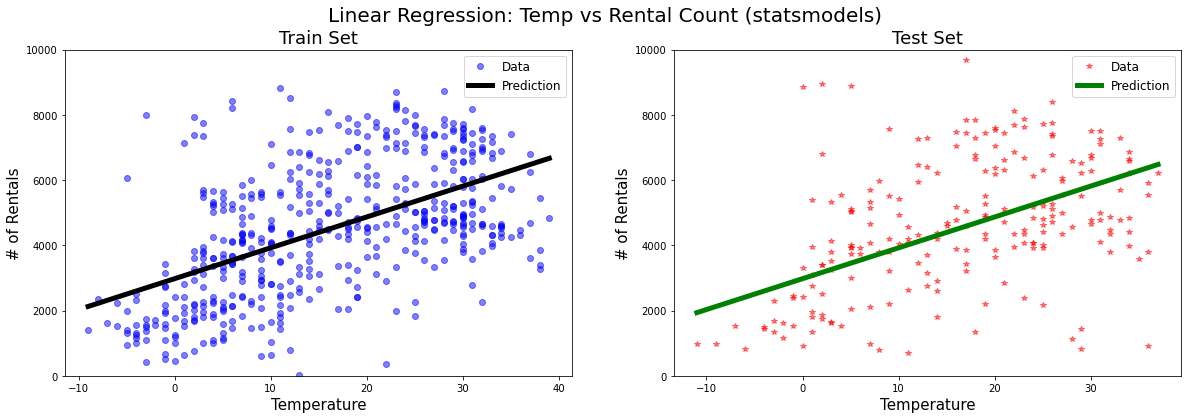

In [30]:
# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

# train data
axes[0].plot(x_train, y_train, 'bo', alpha = 0.5, label = 'Data')
sorted_temp = train_data.sort_values(['temp'])
prediction_lr = results.predict(sm.add_constant(sorted_temp[['temp']]))
axes[0].plot(sorted_temp['temp'], prediction_lr, 'k-', linewidth = 5, label = 'Prediction')
axes[0].set_title('Train Set', fontsize = 18)

# test data
axes[1].plot(x_test, y_test, 'r*', alpha = 0.5, label = 'Data')
sorted_temp = test_data.sort_values(['temp'])
prediction_lr = results.predict(sm.add_constant(sorted_temp[['temp']]))
axes[1].plot(sorted_temp['temp'], prediction_lr, 'g-', linewidth = 5, label = 'Prediction')
axes[1].set_title('Test Set', fontsize = 18)

for i, ax in enumerate(axes):
    ax.set_ylim(0,10000)
    ax.set_xlabel('Temperature', fontsize = 15)
    ax.set_ylabel('# of Rentals', fontsize = 15)
    ax.legend(loc = 'upper right', fontsize = 12)
    
fig.suptitle('Linear Regression: Temp vs Rental Count (statsmodels)', fontsize = 20)
plt.show()

**Check out $R^2$ (remember 1 is perfect prediction)**

In [31]:
print("R^2 Score Train (statsmodels linear regression):", metrics.r2_score(y_train, results.predict(x_train_ca)))
print("R^2 Score Test (statsmodels linear regression):", metrics.r2_score(y_test, results.predict(x_test_ca)))

R^2 Score Train (statsmodels linear regression): 0.29634842804618666
R^2 Score Test (statsmodels linear regression): 0.18898167147912737


Notice that these $R^2$ scores are indeed the same as what we found above using sklearn's linear regression.

**Check out `results.summary()` and see the nice table that statsmodels provides!**

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     214.4
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           9.18e-41
Time:                        13:12:41   Log-Likelihood:                -4522.2
No. Observations:                 511   AIC:                             9048.
Df Residuals:                     509   BIC:                             9057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2977.5275    127.983     23.265      0.000    2726.088    3228.967
temp          94.6300      6.463     14.641      0.000      81.932     107.328
==============================================================================
Omnibus:                       13.052   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.710
Skew:                           0.397   Prob(JB):                      0.00105
Kurtosis:                       2.888   Cond. No.                         33.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Time for Break Out Room 3

**Goal: Compare kNN and linear regression for the same dataset**

**Directions:**
1. Use same dataset from previous Break Out Rooms, with 70-30 train-test split and random state of 42 
1. Create a function that implements linear regression with sklearn or statsmodels
1. Predict on both training and test data
1. Create 2 subplots with the following plotted:
    - Subplot 1: Train set
        - Plot training data in blue
        - Plot linear regression prediction in black
        - Plot kNN prediction (using k = 10) in magenta ('m')
    - Subplot 2: Test set
        - Plot testing data in red
        - Plot linear regression prediction in green
        - Plot kNN prediction (using k = 10) in yellow ('y') 
1. Calculate $R^2$ scores for both train and test sets for both kNN and linear regression 

*Hints:*
- don't forget sort!
- plt.subplots(...) creates subplots

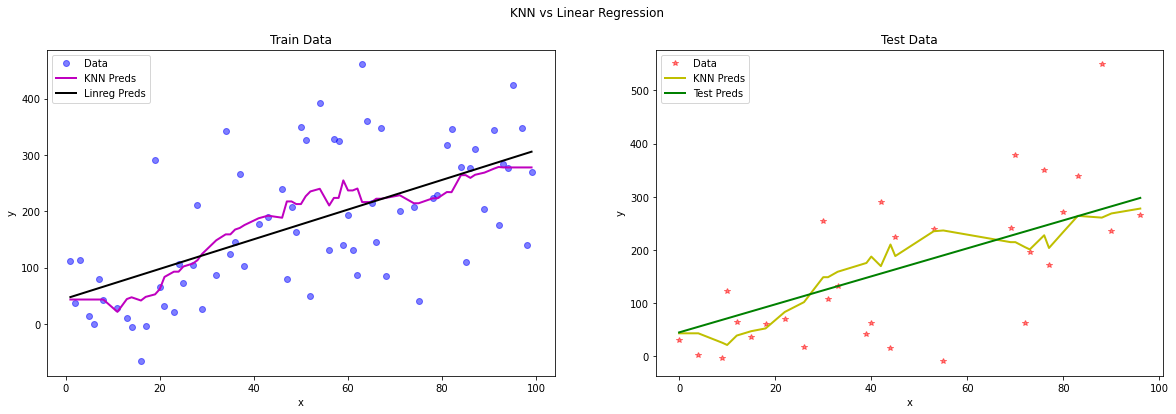

R^2 Score of kNN on training set with k=10: 0.41569204879718624
R^2 Score of kNN on testing set: with k=10 0.3960264344425989
R^2 Score of linear regression on training set 0.3816018646727135
R^2 Score of linear regression on testing set 0.46326892325303626


In [34]:
# %load ../solutions/breakout_3_sol.py
# linear regression
# from statsmodels.api import OLS
# import statsmodels.api as sm

def linreg_model(train_data,test_data):
    # sort
    sorted_train = train_data.sort_values(['x'])
    sorted_test = test_data.sort_values(['x'])

    x_train, x_test, y_train, y_test = sorted_train['x'], sorted_test['x'], sorted_train['y'], sorted_test['y']
    # Add constant to x data
    x_train_ca = sm.add_constant(x_train)
    x_test_ca = sm.add_constant(x_test)

    # Create Linear Regression object
    linreg_model = sm.OLS(y_train, x_train_ca)

    # Fit
    results = linreg_model.fit()

    # predict
    train_preds = results.predict(x_train_ca)
    test_preds = results.predict(x_test_ca)
    
    # find r^2
    r2_train = metrics.r2_score(y_train, results.predict(x_train_ca))
    r2_test = metrics.r2_score(y_test, results.predict(x_test_ca))
    
    return train_preds, test_preds, r2_train, r2_test

def plot_predictions2(k,train_data,test_data, knn_train_preds, knn_test_preds, linreg_train_preds, linreg_test_preds):

    # SubPlots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    axes[0].plot(train_data['x'], train_data['y'], 'bo',alpha = 0.5, label = 'Data' )
    axes[0].plot(train_data['x'], knn_train_preds,'m-', linewidth = 2, markersize = 10,  label = 'KNN Preds')
    axes[0].plot(train_data['x'], linreg_train_preds,'k-', linewidth = 2, markersize = 10, label = 'Linreg Preds')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title("Train Data")
    axes[0].legend()

    axes[1].plot(test_data['x'], test_data['y'], 'r*', alpha = 0.5, label = 'Data' )
    axes[1].plot(test_data['x'], knn_test_preds, 'y-', linewidth = 2, markersize = 10, label = 'KNN Preds')
    axes[1].plot(test_data['x'], linreg_test_preds, 'g-', linewidth = 2, markersize = 10,label = 'Test Preds')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_title("Test Data")
    axes[1].legend()

    fig.suptitle("KNN vs Linear Regression")
    plt.show()

# get predictions
linreg_train_preds,linreg_test_preds, linreg_r2_train, linreg_r2_test = linreg_model(sim_train_data,sim_test_data)

# plot linreg predictions side by side with knn predictions
k=10
plot_predictions2(k, sim_sorted_train, sim_sorted_test, knn_train_preds[1], knn_test_preds[1], linreg_train_preds, linreg_test_preds)

# print r2 scores for knn with k=10 and linreg
print("R^2 Score of kNN on training set with k={}:".format(k), knn_r2_train_scores[1])
print("R^2 Score of kNN on testing set: with k={}".format(k), knn_r2_test_scores[1])
print("R^2 Score of linear regression on training set", linreg_r2_train)
print("R^2 Score of linear regression on testing set", linreg_r2_test)

## Understanding model uncertainty

### Confidence Intervals

In Data Science, a confidence interval (CI) is a type of interval estimate, computed from the statistics of the observed data, that might contain the true value of an unknown population parameter. Simply speaking, a Confidence Interval is a range of values we are fairly sure our true value lies in. 

It is important to remind ourselves here that Confidence Intervals belong to a parameter and not a statistic. Thus, they represent the window in which the true value exists for the entire population when all we have is a sample.

![ci](../fig/confidence_intervals.png)

**See if you can implement a 95% confidence interval using statsmodels**

In [35]:
# Confidence Interval using Stats Model Summary
thresh = 0.05
intervals = results.conf_int(alpha=thresh)

# Renaming column names
first_col = str(thresh/2*100)+"%"
second_col = str((1-thresh/2)*100)+"%"
intervals = intervals.rename(columns={0:first_col,1:second_col})
display(intervals)

,2.5%,97.5%
const,2726.088195,3228.966770
temp,81.932160,107.327814


In the above block of code, ```results.conf_int(alpha=thresh)``` returns a dataframe with columns 0 and 1. We explained Confidence Intervals above where because we assume normal symetric distribution of data, the 95% Confidence Interval means there's 2.5% chance of the true value lying below the values in Column 0 and 2.5% chance of the true value lying above Column 1. 

----------------
### End of Standard Section
---------------

## Extra: Train-Test Split using a mask

In [36]:
#Function to Split data into Train and Test Set
def split_data(data):
    
    #Calculate Length of Dataset
    length = len(data)
    
    #Define Split
    split = 0.7
    
    #Set a random Seed For Shuffling
    np.random.seed(9001)
    
    #Generate a Mask with a X:Y Split
    mask = np.random.rand(length) < split
    
    #Separate train and test data
    data_train = data[mask]
    data_test = data[~mask]
    
    #Return Separately
    return data_train, data_test

In [37]:
#Split data using defined function
train_data_manual, test_data_manual = split_data(bikeshare)
print("Length of Training set:",len(train_data_manual))
print("Length of Testing set:",len(test_data_manual))

Length of Training set: 507
Length of Testing set: 223


In [38]:
## Check that the ratio between test and train sets is right
test_data_manual.shape[0]/(test_data_manual.shape[0]+train_data_manual.shape[0])

0.30547945205479454

## Extra: Implementing the kNN Algorithm by hand

To really understand how the kNN algorithm works, it helps to go through the algorithm line by line in code.

In [39]:
#kNN Algorithm
def knn_algorithm(train, test, k):
    
    #Create any empty list to store our predictions in
    predictions = []
    
    #Separate the response and predictor variables from training and test set:
    train_x = train['temp']
    train_y = train['count']
    test_x  = test['temp']
    test_y  = test['count']
    
    for i, ele in enumerate(test_x):
        
        #For each test point, store the distance between all training points and test point
        distances = pd.DataFrame((train_x.values - ele)**2 , index=train.index)
        distances.columns =['dist']
        
        #display(distances)
        #Then, we sum across the columns per row to obtain the Euclidean distance squared
        ##distances = vec_distances.sum(axis = 1)
        
        #Sort the distances to training points (in ascending order) and take first k points
        nearest_k = distances.sort_values(by='dist').iloc[:k]
        
        #For simplicity, we omitted the square rooting of the Euclidean distance because the
        #square root function preserves order. 
        
        #Take the mean of the y-values of training set corresponding to the nearest k points
        k_mean = train_y[nearest_k.index].mean()
        
        #Add on the mean to our predicted y-value list
        predictions.append(k_mean)
    
    #Create a dataframe with the x-values from test and predicted y-values  
    predict = test.copy()  
    predict['predicted_count'] = pd.Series(predictions, index=test.index)
    
    return predict

Now to run the algorithm on our dataset with $k = 5$:

In [40]:
#Run the kNN function 

k = 5
predicted_knn = knn_algorithm(train_data, test_data, k)
predicted_knn.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count,predicted_count
469,2.0,5.0,0.0,5.0,1.0,2.0,17.0,20.0,86.3333,0.179725,9696.0,4616.4
148,3.0,8.0,0.0,4.0,1.0,1.0,30.0,30.0,42.3750,0.164796,4792.0,6534.4
303,1.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,31.1250,0.240050,3243.0,3060.2
356,1.0,3.0,0.0,6.0,0.0,1.0,3.0,6.0,35.0417,0.225750,4118.0,3060.2
516,2.0,4.0,0.0,2.0,1.0,1.0,23.0,27.0,39.0417,0.273629,6691.0,6713.2


We want to have a way to evaluate our predictions from the kNN algorithm with $k=5$. One way is to compute the $R^2$ coefficient. Let's create a function for that:

In [41]:
#Test predictions in comparison to true value of test set
def evaluate(predicted, true):
    
    #Find the squared error:
    squared_error = (predicted['predicted_count'] - true['count'])**2
    
    #Finding the mean squared error:
    error_var = squared_error.sum()
    sample_var = ((true['count'] - true['count'].mean())**2).sum()
    r = (1 - (error_var / sample_var))
    return r

Then let's apply this function to our predictions:

In [42]:
print("Length of Test Data:",len(test_data))
print("R^2 Score of kNN test:", evaluate(predicted_knn, test_data))

Length of Test Data: 219
R^2 Score of kNN test: 0.15985957302330167


In [43]:
predicted_knn_train = knn_algorithm(test_data, train_data, k)
print("R^2 Score of kNN train:", evaluate(predicted_knn_train, train_data))

R^2 Score of kNN train: 0.21984316699072837


## Extra: Computing different performance metrics by hand

Now, we will compute metrics that can be used to assess fit.

**Note: sklearn.metrics is class of functions that consists of all the metrics we care about to evaluate our models. While it is not hard to implement them yourself, it is helpful to go through http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.**

In [44]:
model = sm.OLS(y_train, x_train_ca)
results = model.fit()

#Predict on train and test
y_pred_train = results.predict(x_train_ca)
y_pred_test = results.predict(x_test_ca)

#Calc squared error
squared_error_train = (y_pred_train - y_train)**2
squared_error_test = (y_pred_test - y_test)**2

#Calc mean squared error
error_var_train = squared_error_train.mean()
error_var_test = squared_error_test.mean()

#Calc variance
sample_var_train = ((y_train - y_train.mean())**2).mean()
sample_var_test = ((y_test - y_test.mean())**2).mean()

#Calc R^2
r_sq_train = 1 - error_var_train/sample_var_train
r_sq_test = 1 - error_var_test/sample_var_test

print('MSE train:', error_var_train, 'R^2 train:', r_sq_train)
print('MSE test:', error_var_test, 'R^2 test:', r_sq_test)

MSE train: 2845979.0374342627 R^2 train: 0.29634842804618666
MSE test: 3357507.577228926 R^2 test: 0.18898167147912737


---